In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py, os

from astropy.io import fits
from functools import reduce

from msfm.utils import files
from msfm.utils.files import load_pixel_file
from msfm.utils.maps import map_to_data_vec, data_vec_to_map

24-05-06 16:21:00   imports.py INF   Setting up healpy to run on 10 CPUs 


In this notebook, the `.h5` file containing the correct pixel indices for all of the masks used in the project are generated

Based off [KiDS_1000_index_file.ipynb](https://cosmo-gitlab.phys.ethz.ch/jafluri/arne_handover/-/blob/main/carpet/notebooks/KiDS_1000_index_file.ipynb) by Janis Fluri.

### global constants

In [3]:
conf = files.load_config( "../../configs/v8/linear_bias.yaml")

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

n_side_down = conf["analysis"]["n_side_down"]

pixels_dir = f"../../data/DESY3_pixels_v11_{n_side}_octant.h5"

# Transformations

### HEALPix Symmetry transformations

In [4]:
# mirror (up down)
def mirror_pix(pix, nside=n_side, lr=False):
    theta, phi = hp.pix2ang(ipix=pix, nside=n_side)
    if lr:
        phi = 2*np.pi - phi
    else:
        theta = np.pi - theta
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)

    # make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))

    return new_pix

# 90 degree rotations
def rotate_pix(pix, n_rot=1, nside=n_side):
    theta, phi = hp.pix2ang(ipix=pix, nside=nside)
    phi = (phi + n_rot*np.pi/2) % (2*np.pi)
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)

    # make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))
    
    return new_pix

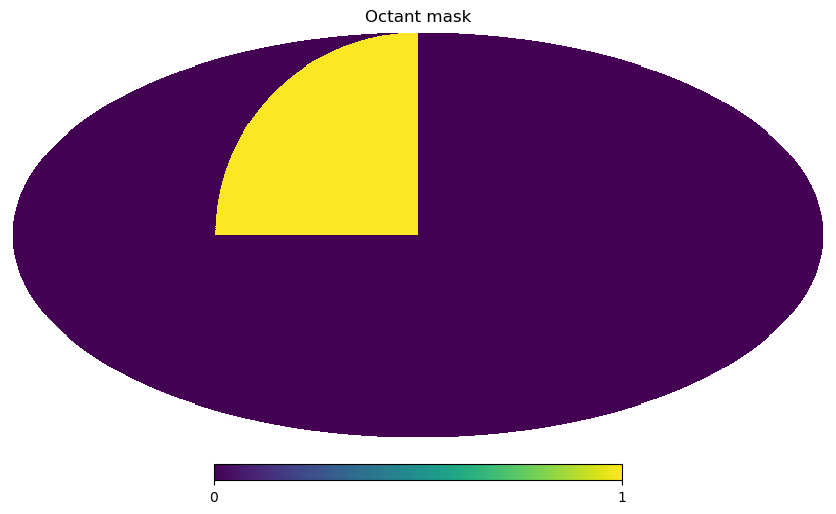

In [5]:
lon, lat = hp.pix2ang(nside=n_side, ipix=range(n_pix), nest=False, lonlat=True)
octant_mask = (lon < 90) & (0 < lat)

octant_map = np.zeros(n_pix, dtype=int)
octant_map[octant_mask] = 1

hp.mollview(octant_map, nest=False, title="Octant mask")

octant_indices_ring = np.arange(n_pix)[octant_mask]
octant_indices_nest = hp.ring2nest(n_side, octant_indices_ring)

# Metacal

In [6]:
# exclude the 0th bin, which includes all of the others
tomo_inds = [1, 2, 3, 4]
z_bins = conf["survey"]["metacal"]["z_bins"]

### symmetry transforms (all patches for all bins)
We're throwing away half of the sphere on purpose, to keep it simple and four footprints like for the main DES footprint

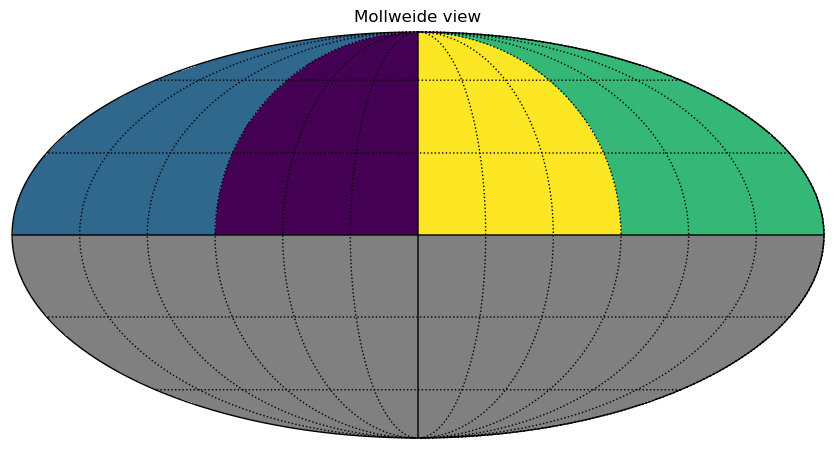

In [7]:
patch_0 = octant_indices_ring
patch_1 = rotate_pix(patch_0, n_rot=1)
patch_2 = rotate_pix(patch_0, n_rot=2)
patch_3 = rotate_pix(patch_0, n_rot=3)

# all patches have the same size
assert len(patch_0) == len(patch_1) == len(patch_2) == len(patch_3)
# no index occurs more than once
assert reduce(np.intersect1d, ([patch_0, patch_1, patch_2, patch_3])).size == 0

# plot the total mask
full_mask = np.full(n_pix, hp.UNSEEN)
full_mask[patch_0] = 0
full_mask[patch_1] = 1
full_mask[patch_2] = 2
full_mask[patch_3] = 3

hp.mollview(full_mask, cbar=False)
hp.graticule()

patches = np.stack([patch_0, patch_1, patch_2, patch_3])

# the same for all four redshift bins
patches_tomo = [patches for _ in range(4)]

In [8]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    base_grp = f.create_group("metacal/")

    base_grp.attrs["info"] = "This group contains the datasets related to the Metacalibration galaxy sample. "    

    dset = f.create_dataset("metacal/gamma_2_sign", data=[1, 1, 1, 1], dtype="i")
    dset.attrs["info"] = "This dataset contains the factor by which the gamma_2 component of the shear maps has to " \
                         "be multiplied. For patches that contain mirroring, gamma_2 needs to be multiplied by " \
                         "minus one. The rotations by 90 degrees are fine."

    for patch, z_bin in zip(patches_tomo, z_bins):
        dset = f.create_dataset(f"metacal/patches/{z_bin}", data=patch, dtype="i")
        dset.attrs["info"] = f"This dataset contains all pixel ids for a map with nside {n_side} in RING ordering, " \
                             "to cut out 4 DES Y3 data patches simulataneously. " \
                             "The shape is (N_patches, N_pix), the first patch is the original (but rotated) one. " \
                             f"Data is for tomo bin: {z_bin}"

# Maglim
Here, identical to Metacal

In [9]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    dset = f.create_dataset(f"maglim/patches", data=patches, dtype="i")
    dset.attrs["info"] = f"This dataset contains all pixel ids for a map with nside {n_side} in RING ordering, " \
                        "to cut out 4 DES Y3 data patches simulataneously. " \
                        "The shape is (N_patches, N_pix), the first patch is the original (but rotated) one. " \
                        f"Data is for all tomo bins"

### Extend the indices, i.e. padding for network

nside=16, npix=400
nside=512, npix=409600


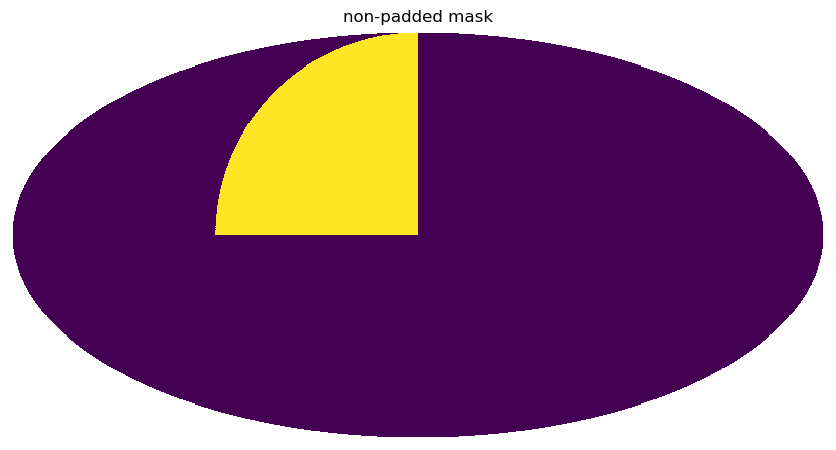

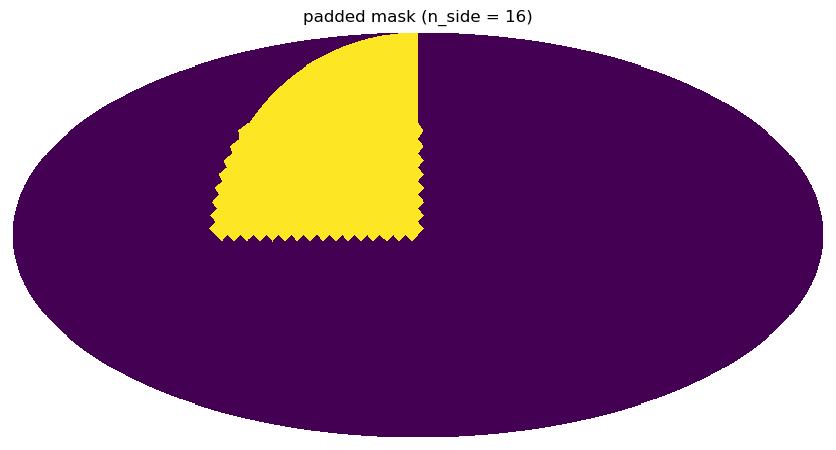

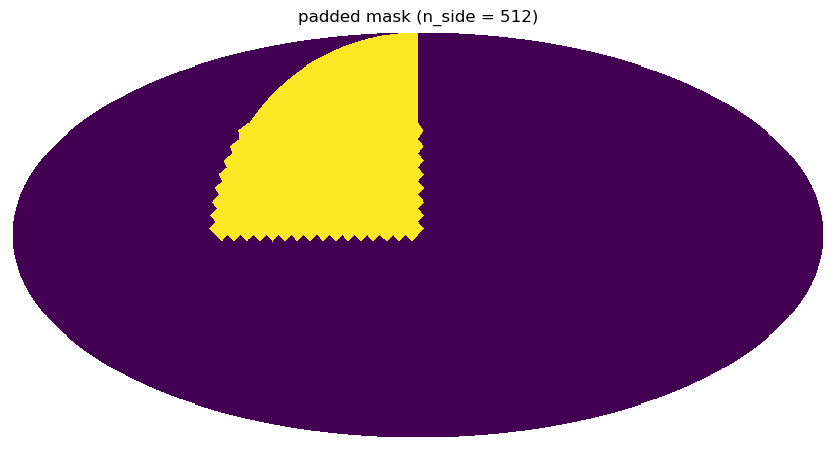

In [10]:
octant_map_nest = hp.reorder(octant_map, r2n=True)
hp.mollview(octant_map_nest, nest=True, title="non-padded mask", cbar=False)

# minimal possible nside for the network to downsample
padded_mask_nest = hp.ud_grade(octant_map_nest, nside_out=n_side_down, order_in='NEST', order_out='NEST', pess=False, power=-2)
padded_mask_nest[padded_mask_nest > 0] = 1
print(f"nside={n_side_down}, npix={np.sum(padded_mask_nest)}")
hp.mollview(padded_mask_nest, nest=True, title=f"padded mask (n_side = {n_side_down})", cbar=False)

padded_mask_nest = hp.ud_grade(padded_mask_nest, nside_out=n_side, order_in='NEST', order_out='NEST')
padded_mask_nest[padded_mask_nest > 0] = 1
print(f"nside={n_side}, npix={np.sum(padded_mask_nest)}")
hp.mollview(padded_mask_nest, nest=True, title=f"padded mask (n_side = {n_side})", cbar=False)

In [11]:
# get the pixel in nest ordering (from the mask on map level)
data_vector_nest_pix = np.arange(n_pix)[padded_mask_nest > 0.5]

print(f"Non padded: {len(octant_indices_nest)} pixels")
print(f"Padded:     {len(data_vector_nest_pix)} pixels")
assert len(data_vector_nest_pix) > len(octant_indices_nest)

Non padded: 392960 pixels
Padded:     409600 pixels


In [12]:
# save the indices
with h5py.File(pixels_dir, "a") as f:
    dset = f.create_dataset("data_vec", shape=data_vector_nest_pix.shape, dtype="i", data=data_vector_nest_pix)
    dset.attrs["info"] = "This dataset contains all relevant pixels from the original rotated " \
                         "DES Y3 patch in NEST ordering, such that it can be downsampled to " \
                         f"an nside of {n_side_down} without the need of additional padding."

### Note:

Now comes the tricky part:

The idea for a fast and efficient cut out procedure of the simulated maps is that one can generate data vectors that only consist of zeros (including the padding) and then fill in the necessary pixels. To make this possible, we need to know the correspondence of the pixels inside the data vector (NEST ordering) with pixels in RING ordering of the full sky map.

In [13]:
# dict for fast look up
non_tomo_pixels_nest_ext_look_up = {}
for i, pix_id in enumerate(data_vector_nest_pix):
    non_tomo_pixels_nest_ext_look_up.update({pix_id: i})

### Metacal

In [14]:
# list for correspondences
tomo_metacal_corresponding_pix = []
counter = 0
# loop over tomographic bins, patch_indices are in RING ordering
for patch_index, name in zip([octant_indices_ring for _ in range(len(z_bins))], z_bins):
    print("Starting with bin: ", name)
    nest_patch = hp.ring2nest(n_side, patch_index)
    
    # now we need to get the index in non_tomo_pixels_nest_ext that corresponds to the pix id
    corresponding_pix = []
    for pix_id in nest_patch:
        corresponding_pix.append(non_tomo_pixels_nest_ext_look_up[pix_id])
    tomo_metacal_corresponding_pix.append(np.array(corresponding_pix))
    counter += 1

Starting with bin:  metacal1
Starting with bin:  metacal2
Starting with bin:  metacal3
Starting with bin:  metacal4


In [15]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    grp = f.create_group("metacal/patch_to_data_vec")
    for i_bin, name in zip(range(len(tomo_inds)), z_bins):
        current_patch = tomo_metacal_corresponding_pix[i_bin]
        dset = grp.create_dataset(name, shape=current_patch.shape, dtype="i", data=current_patch)
        dset.attrs["info"] = "This dataset contains the pixel ids that map the patches in RING " \
                             "ordering to the data vector in NEST ordering. " \
                             f"Data is for tomo bin: {name}"

### Maglim

In [16]:
maglim_patch_nest = hp.ring2nest(n_side, patches[0,:])

# now we need to get the index in non_tomo_pixels_nest_ext that corresponds to the pix id
maglim_corresponding_pix = []
for pix_id in maglim_patch_nest:
    maglim_corresponding_pix.append(non_tomo_pixels_nest_ext_look_up[pix_id])

maglim_corresponding_pix = np.array(maglim_corresponding_pix)

In [17]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    dset = f.create_dataset("maglim/patch_to_data_vec", shape=maglim_corresponding_pix.shape, dtype="i", data=maglim_corresponding_pix)
    dset.attrs["info"] = "This dataset contains the pixel ids that map the patches in RING " \
                            "ordering to the data vector in NEST ordering. " \
                            f"Data is for all tomo bins"

### Survey systematics maps

In [18]:
# maglim_z_bins = conf["survey"]["maglim"]["z_bins"]

# # potentially only consider the first four maglim bins
# tomo_sys_dv = tomo_sys_dv[:len(maglim_z_bins)]

# # save the patches
# with h5py.File(pixels_dir, "a") as f:
#         for sys_map, sys_dv, z_bin in zip(tomo_sys_map, tomo_sys_dv, maglim_z_bins):
#             # map
#             dset = f.create_dataset(f"maglim/systematics/map/{z_bin}", data=sys_map, dtype="f4")
#             dset.attrs["info"] = f"This dataset contains the rotated maglim systematics maps in RING ordering format for bin {i}"

#             # data vector
#             dset = f.create_dataset(f"maglim/systematics/data_vector/{z_bin}", data=sys_dv, dtype="f4")
#             dset.attrs["info"] = f"This dataset contains the rotated maglim systematics maps in datavector format (NEST ordering) for bin {i}"

# inspect the file

In [19]:
with h5py.File(pixels_dir, "r") as f:
    ic(f.keys())

    ic(f["metacal"].keys())
    ic(f["maglim"].keys())
    ic(f["data_vec"][:].shape)

    ic(f["maglim/patches"][:].shape)

    

ic| f.keys(): <KeysViewHDF5 ['data_vec', 'maglim', 'metacal']>
ic| f["metacal"].keys(): <KeysViewHDF5 ['gamma_2_sign', 'patch_to_data_vec', 'patches']>
ic| f["maglim"].keys(): <KeysViewHDF5 ['patch_to_data_vec', 'patches']>
ic| f["data_vec"][:].shape: (409600,)
ic| f["maglim/patches"][:].shape: (4, 392960)


## testing

In [20]:
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = load_pixel_file(conf="../../configs/v8/linear_bias_octant.yaml")

metacal_tomo_patches_pix = patches_pix_dict["metacal"]
metacal_tomo_corresponding_pix = corresponding_pix_dict["metacal"]

maglim_patches_pix = patches_pix_dict["maglim"]
maglim_corresponding_pix = corresponding_pix_dict["maglim"]

24-05-06 16:21:03     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512_octant.h5 


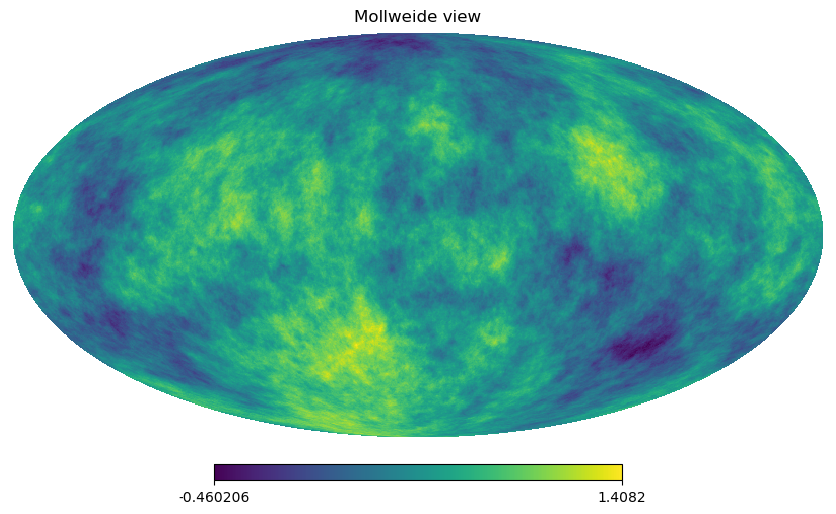

In [21]:
# we start be generating a random map
np.random.seed(11)
Cl = np.arange(1, 1001)**-3.
example_map = hp.synfast(cls=Cl, nside=n_side)

z_min = np.min(example_map)
z_max = np.max(example_map)

# plot
hp.mollview(example_map, min=z_min, max=z_max)

### cut outs

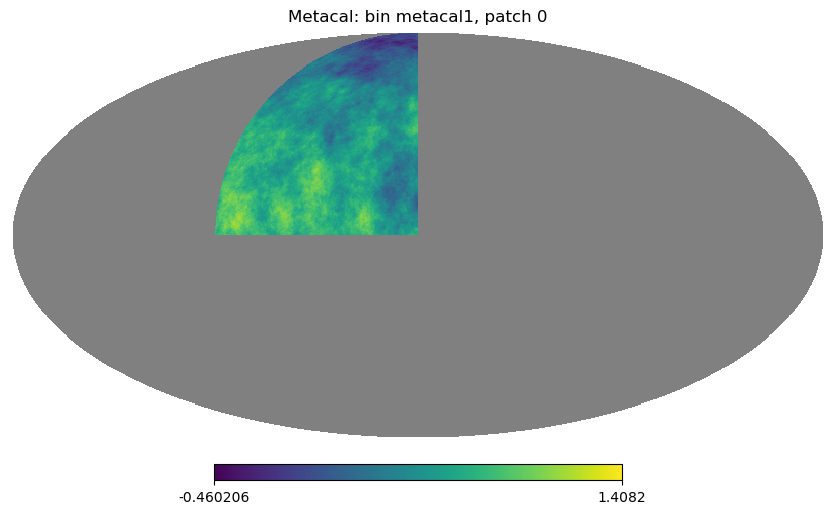

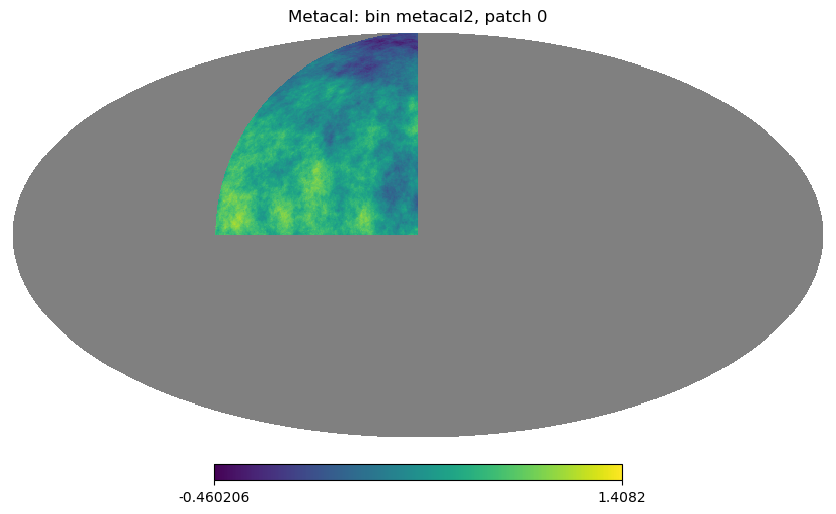

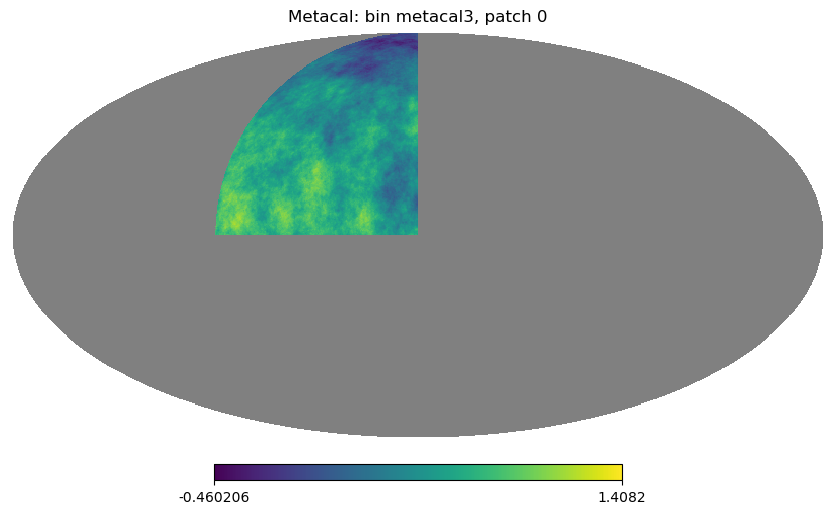

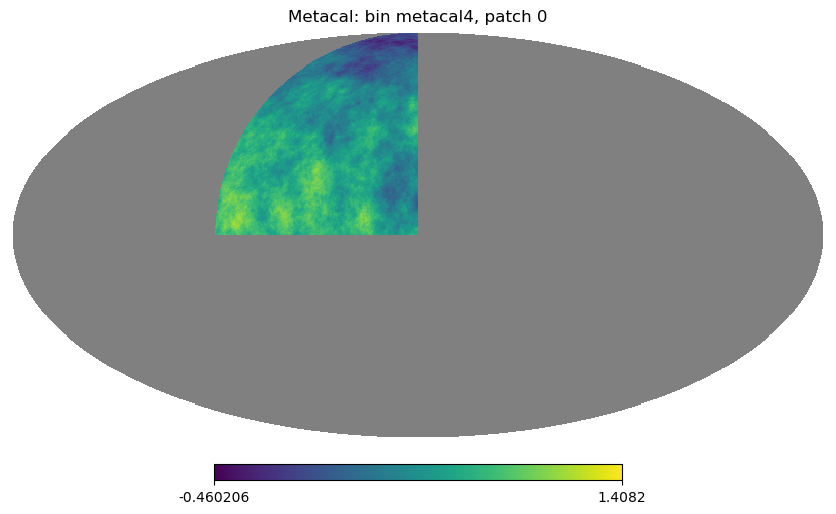

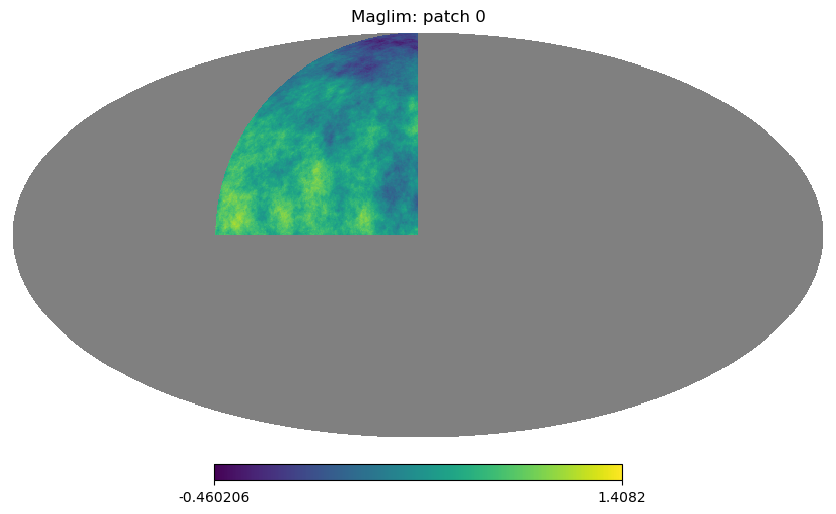

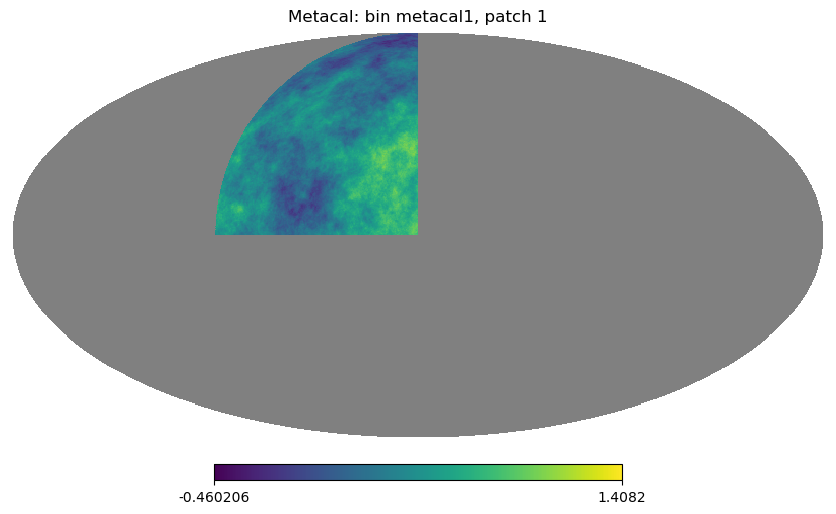

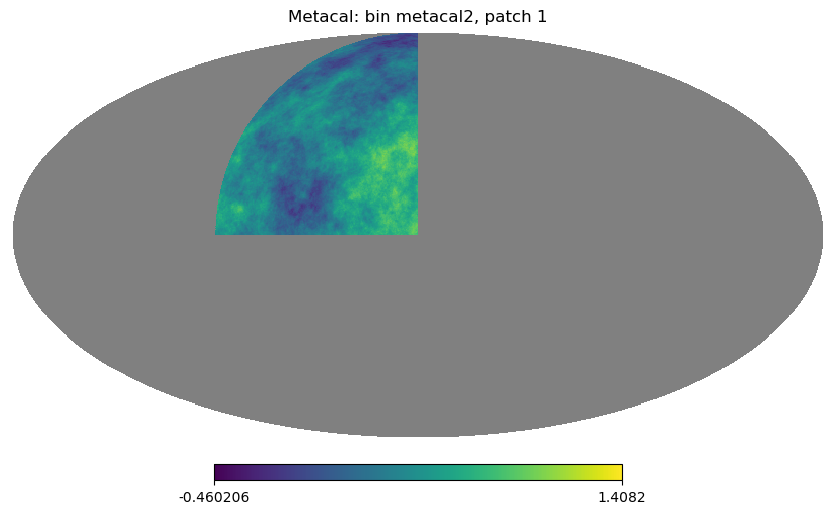

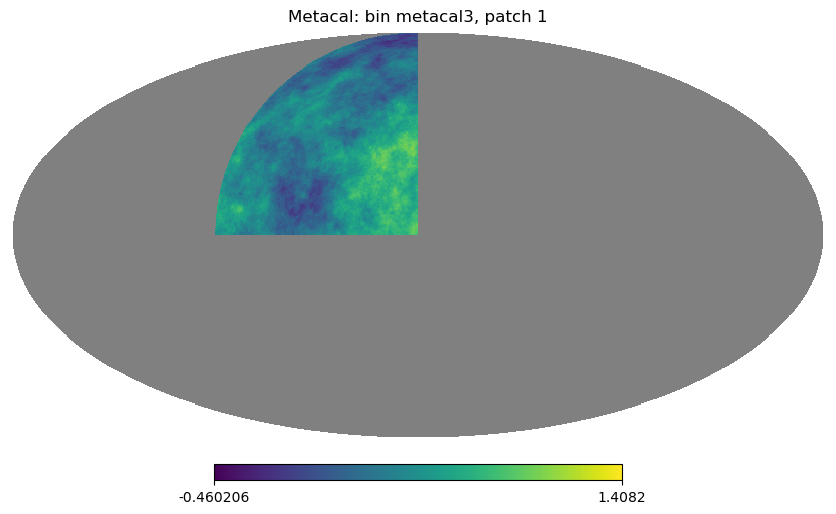

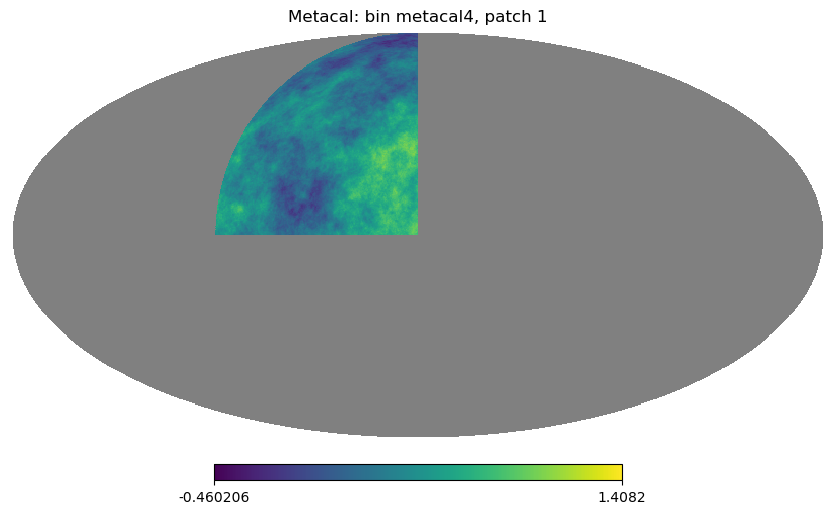

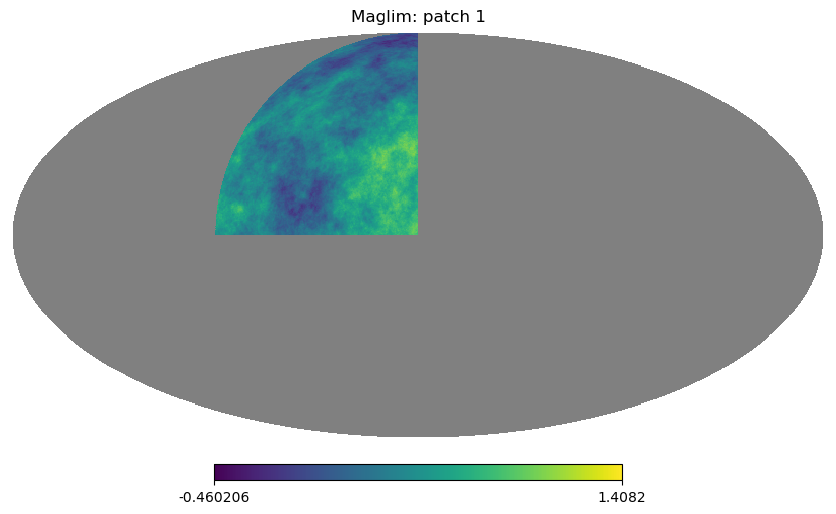

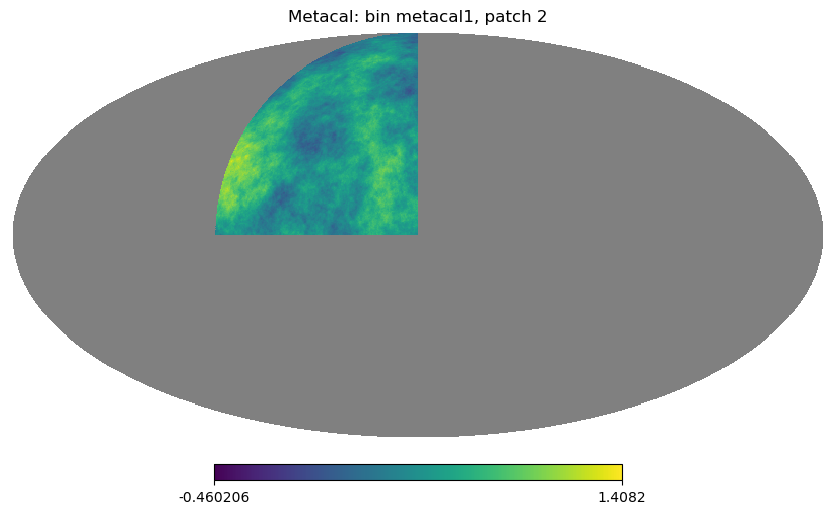

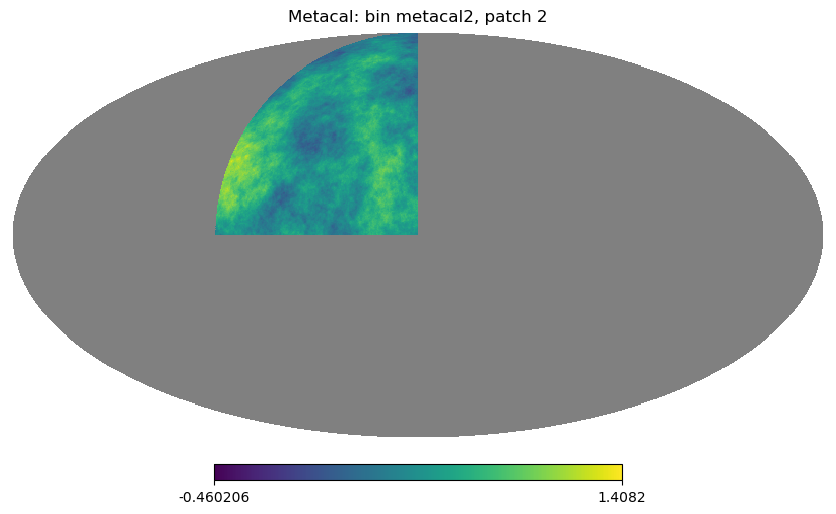

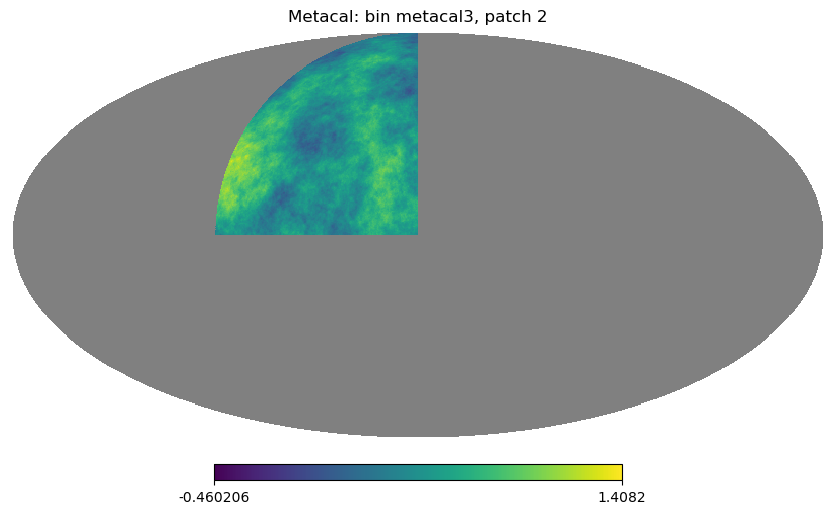

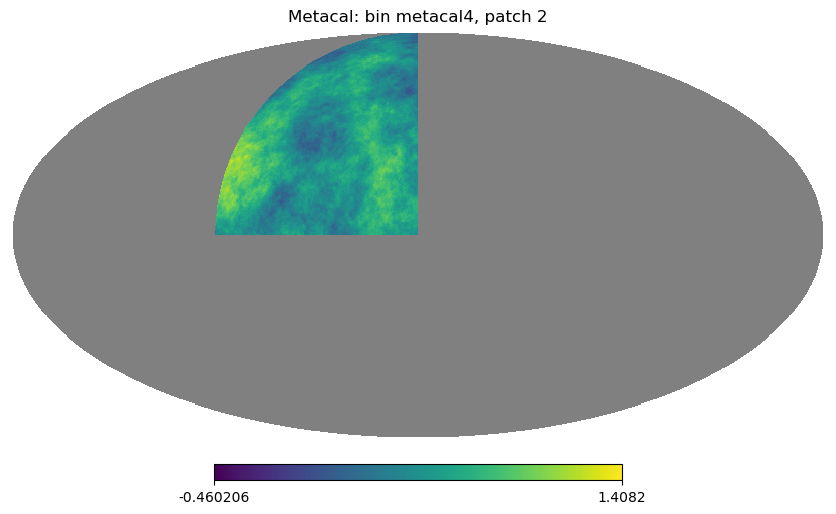

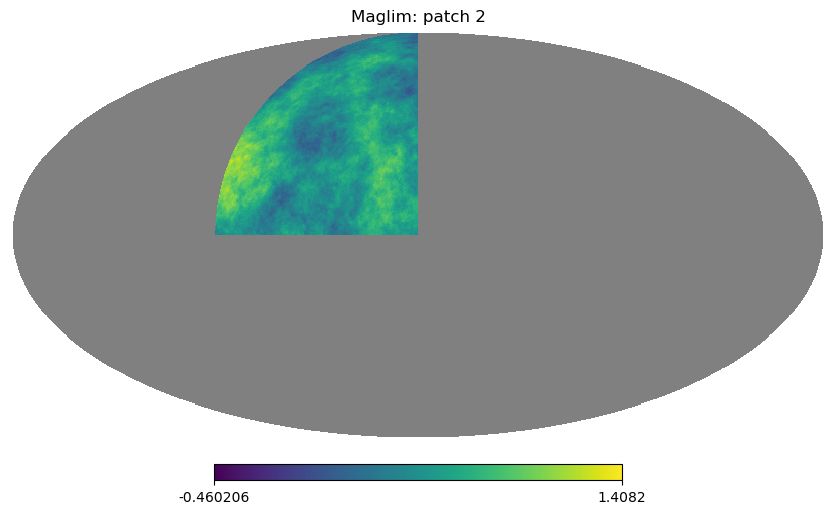

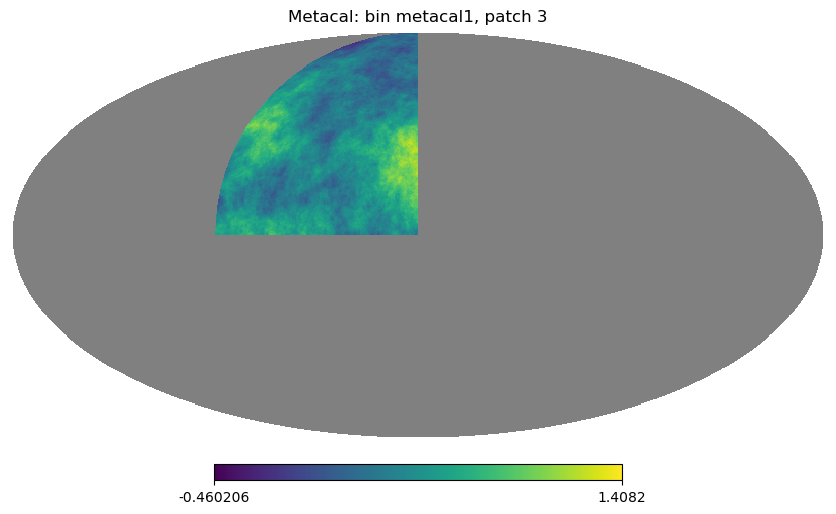

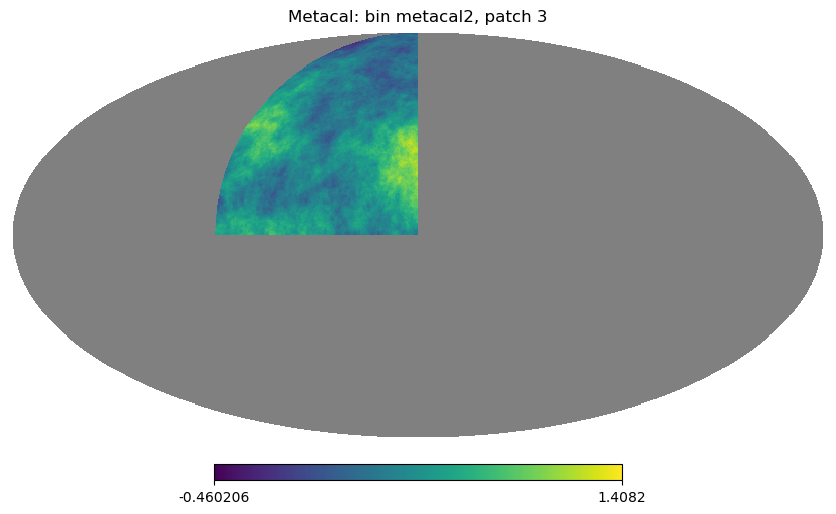

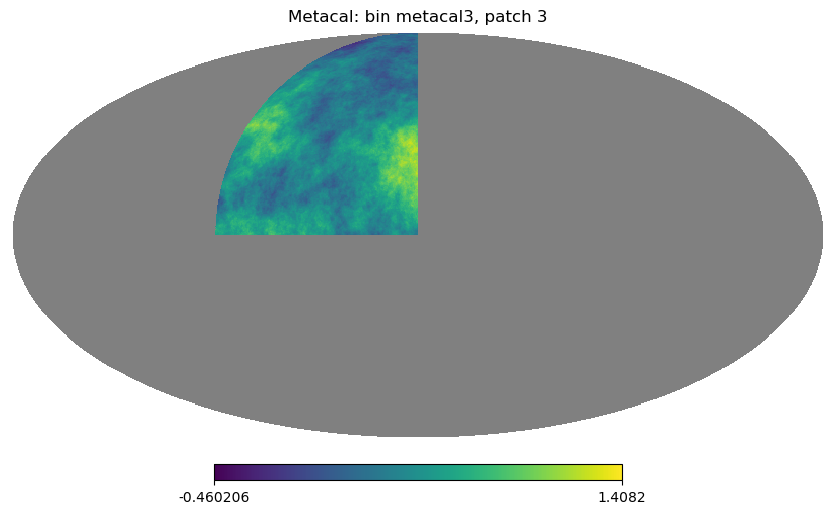

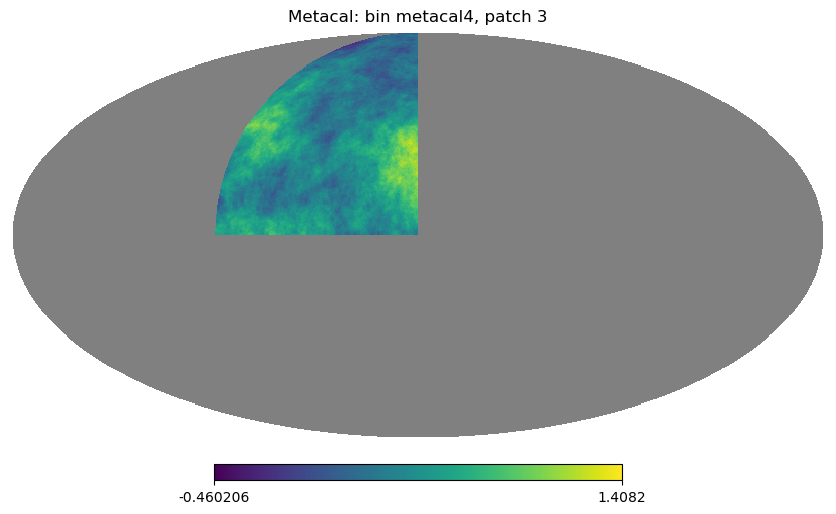

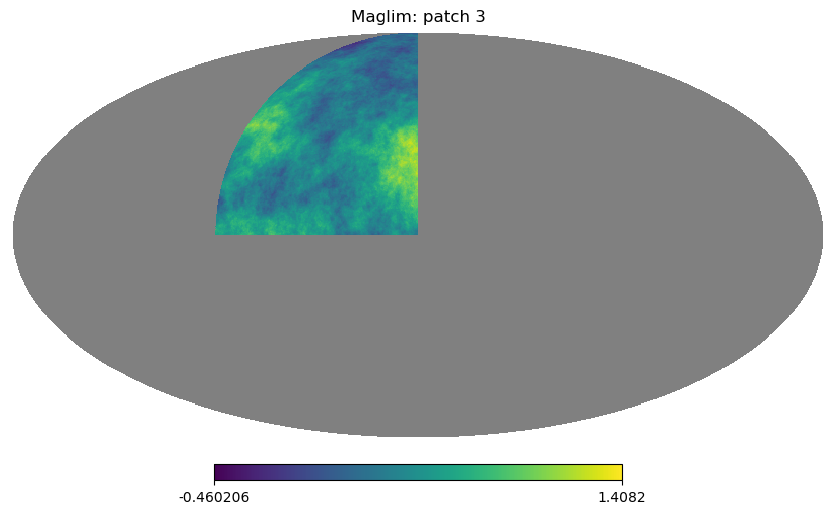

In [22]:
for patch_id in range(4):
    # Metacal
    for z_id, z_bin in zip(range(4), conf["survey"]["metacal"]["z_bins"]):
        base_patch = metacal_tomo_patches_pix[z_id][0]
        current_patch = metacal_tomo_patches_pix[z_id][patch_id]

        m_plot = np.full(n_pix, hp.UNSEEN)
        m_plot[base_patch] = example_map[current_patch]
        hp.mollview(m_plot, min=z_min, max=z_max, title=f"Metacal: bin {z_bin}, patch {patch_id}")

    # Maglim
    base_patch = maglim_patches_pix[0]
    current_patch = maglim_patches_pix[patch_id]

    m_plot = np.full(n_pix, hp.UNSEEN)
    m_plot[base_patch] = example_map[current_patch]
    hp.mollview(m_plot, min=z_min, max=z_max, title=f"Maglim: patch {patch_id}")

### data vectors

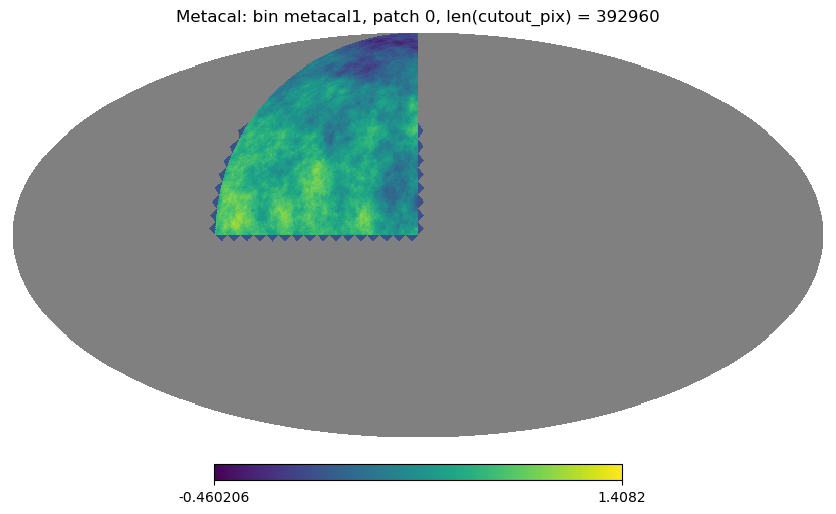

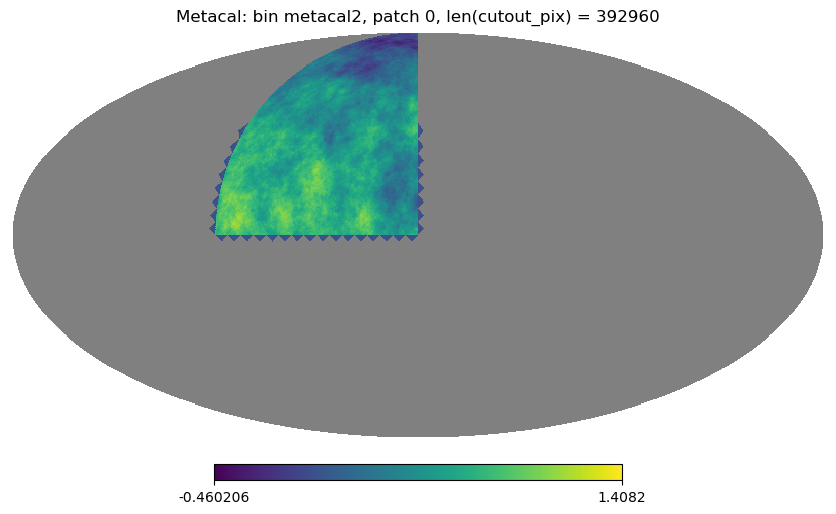

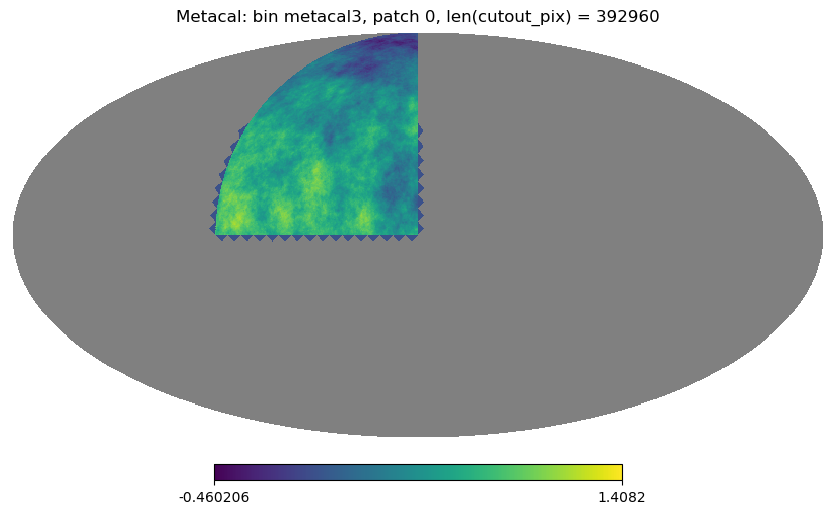

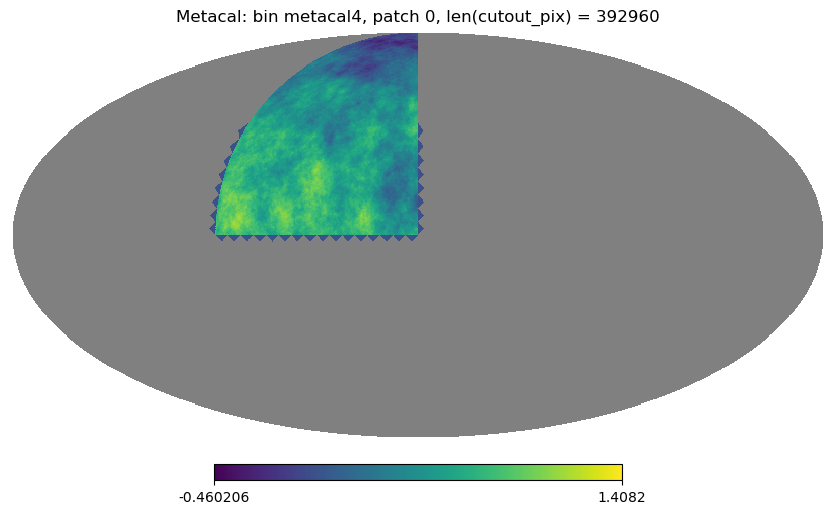

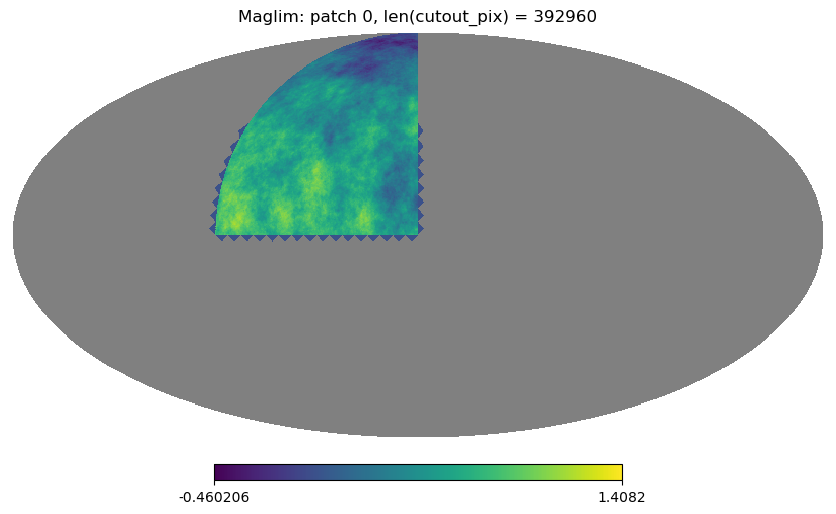

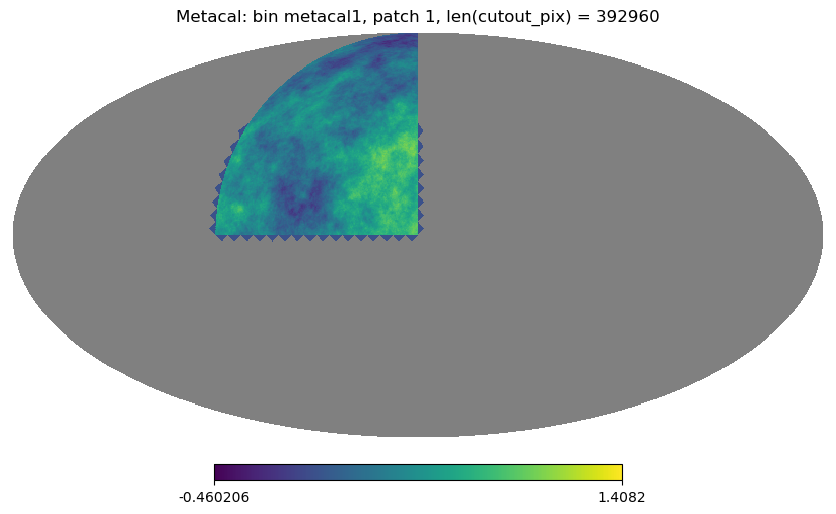

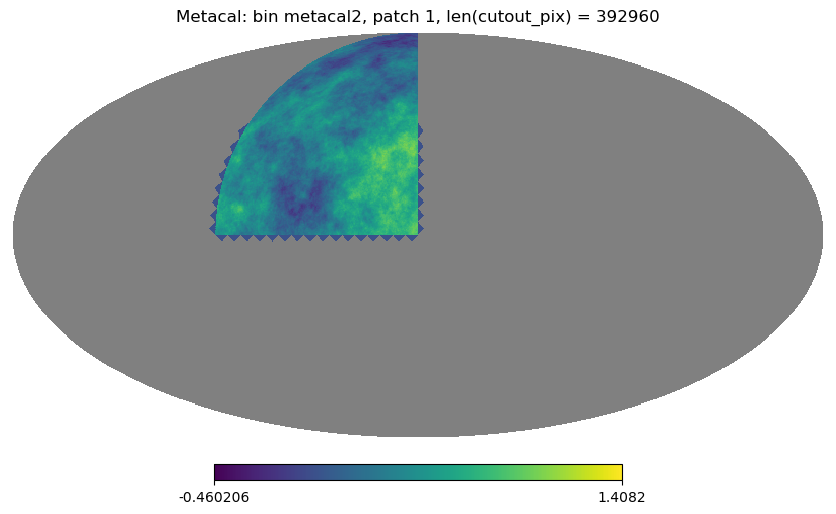

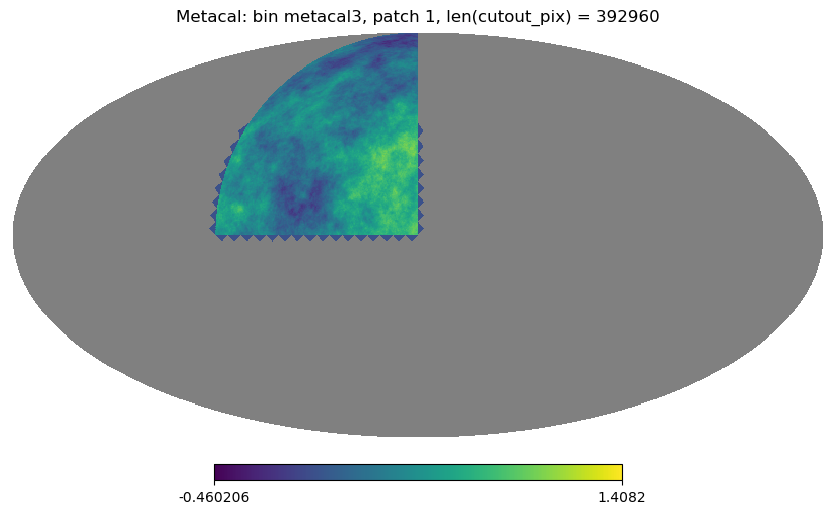

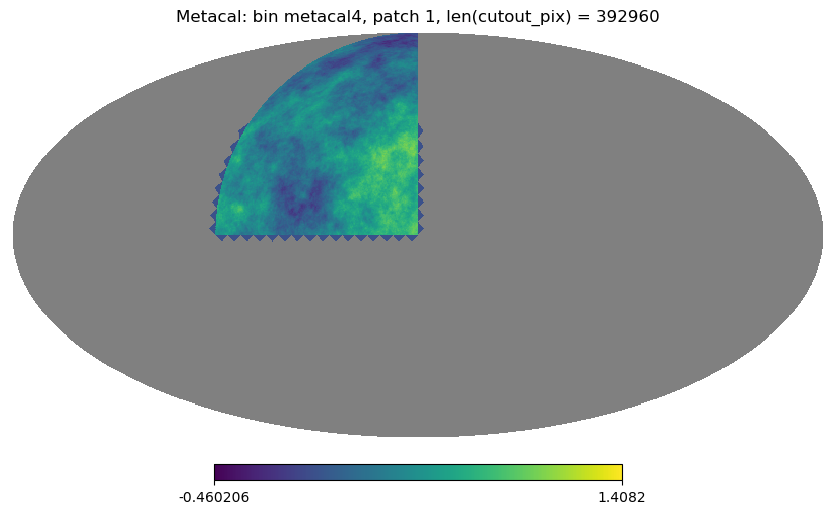

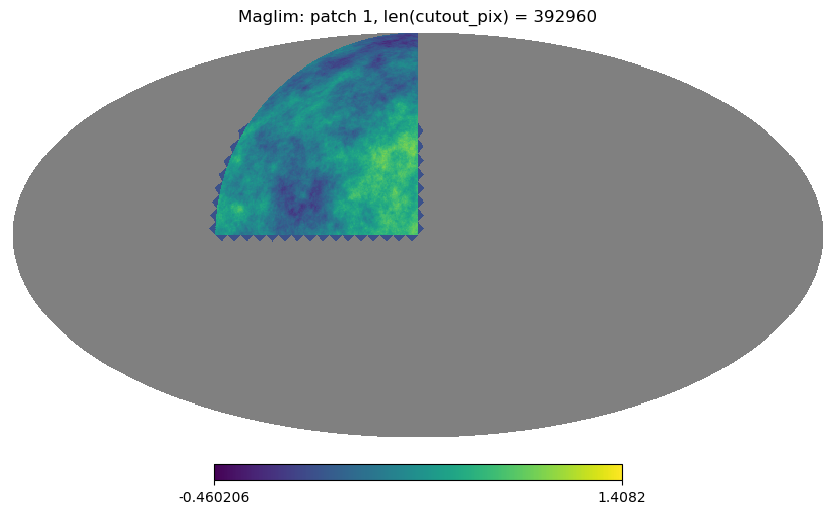

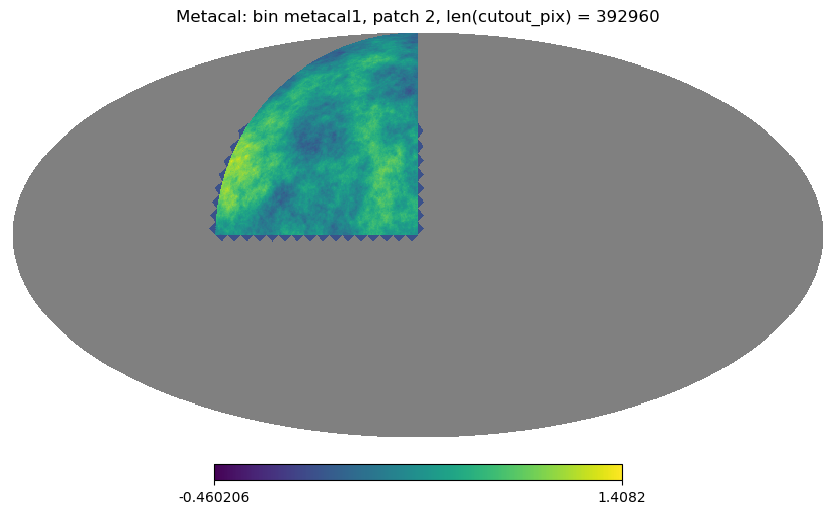

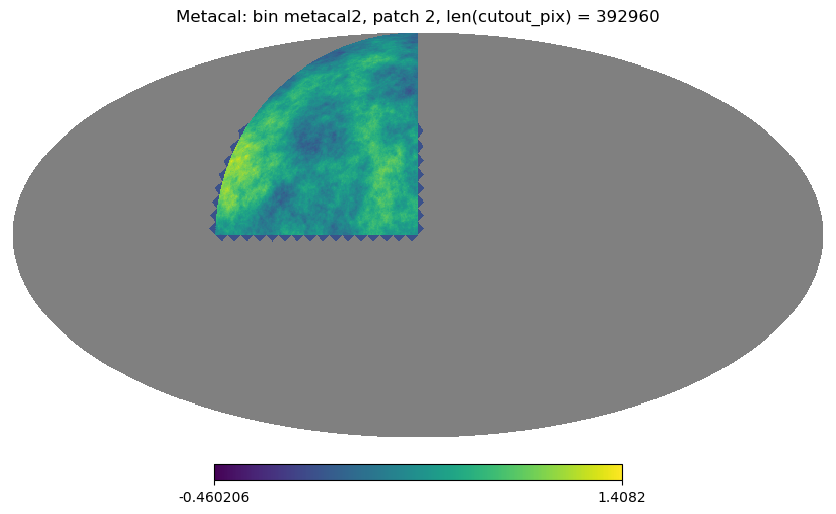

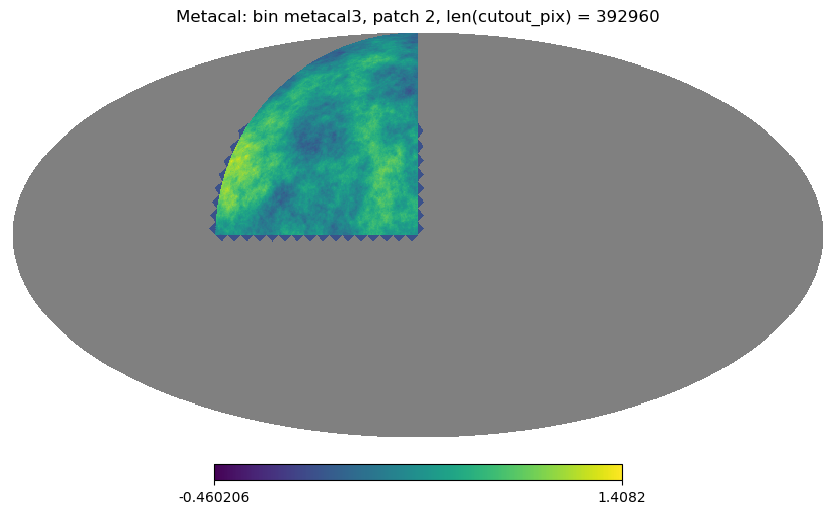

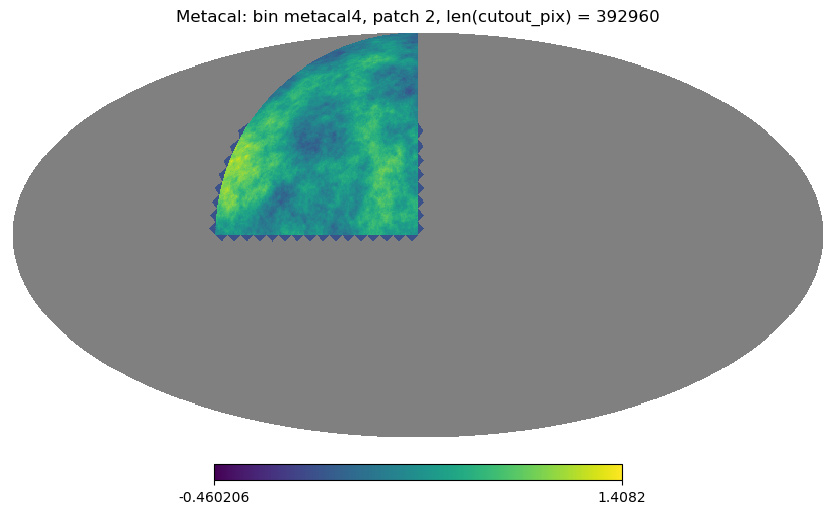

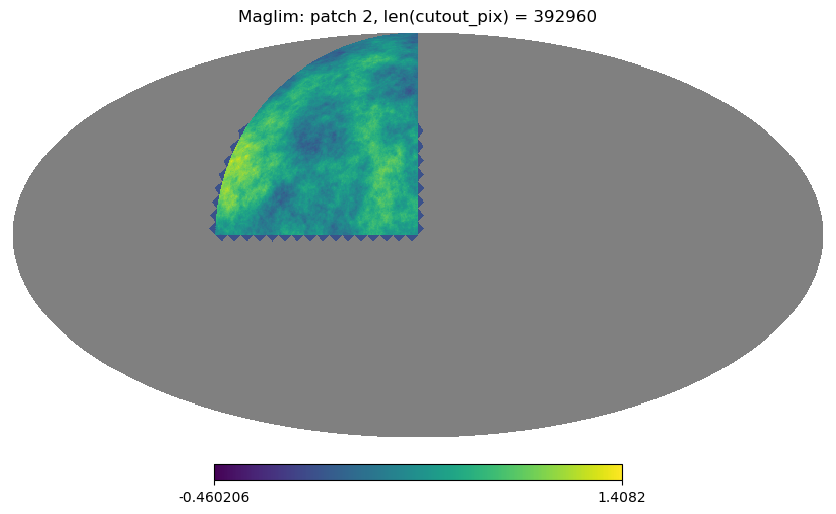

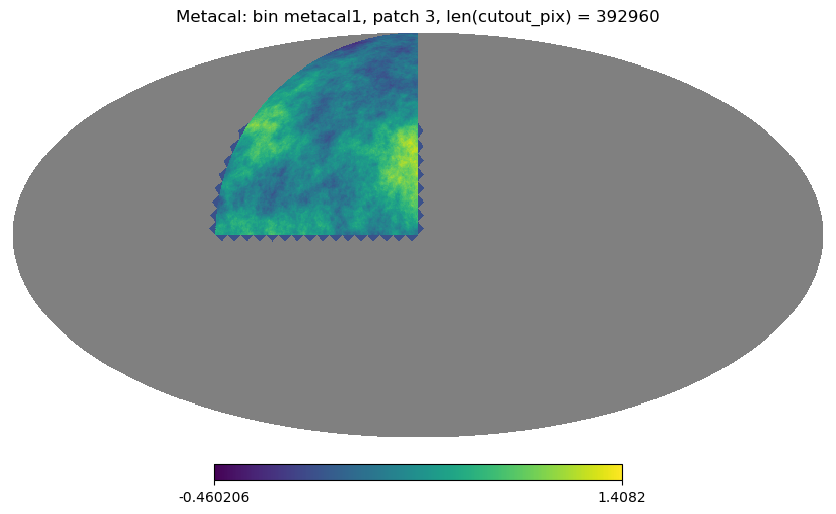

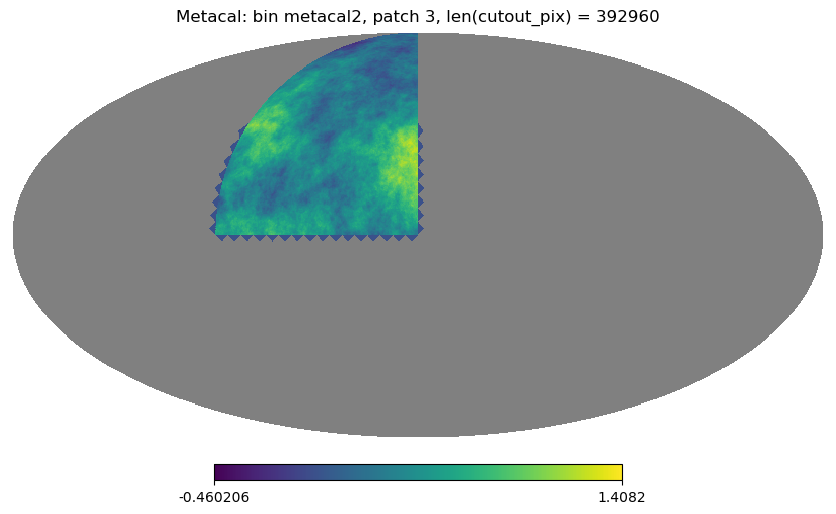

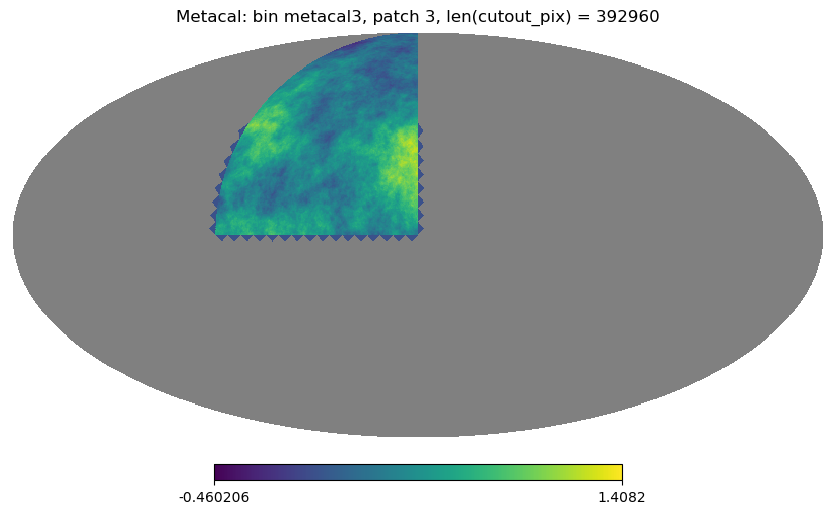

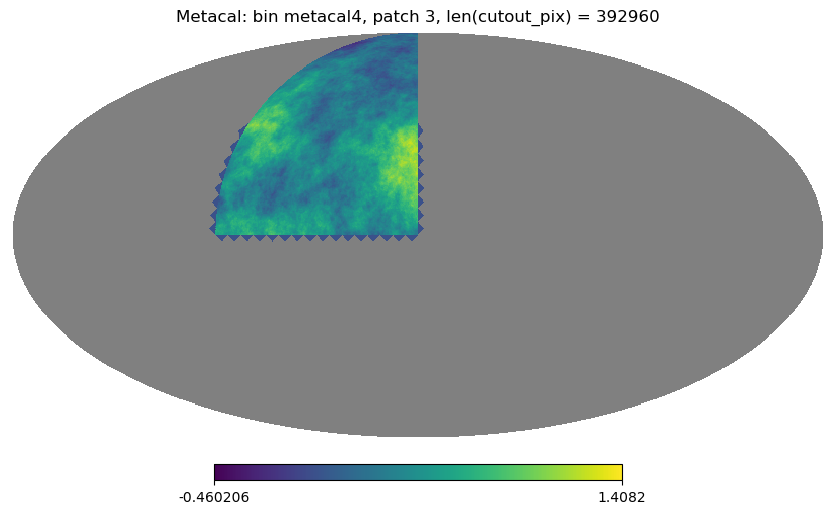

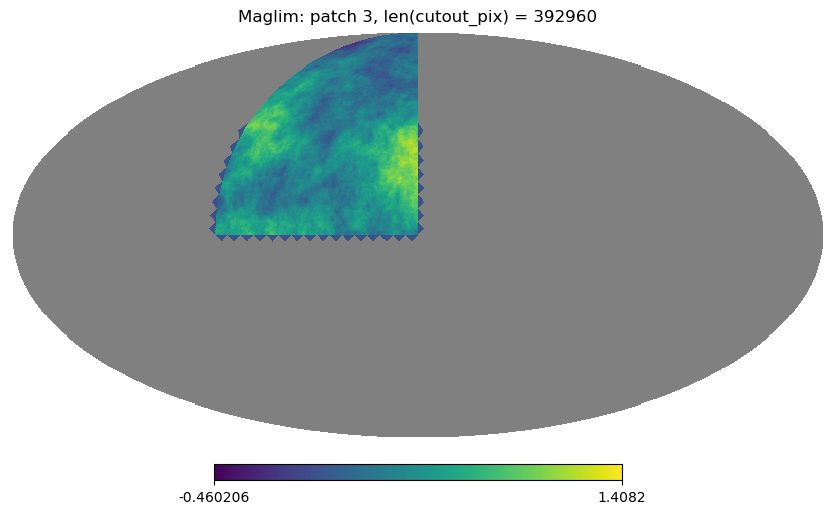

In [23]:
for patch_id in range(4):
    # Metacal
    for z_id, z_bin in zip(range(4), conf["survey"]["metacal"]["z_bins"]):
        cutout_pix = metacal_tomo_patches_pix[z_id][patch_id]
        corresponding_pix = metacal_tomo_corresponding_pix[z_id]

        data_vec = map_to_data_vec(example_map, len(data_vec_pix), corresponding_pix, cutout_pix)

        m_plot = np.full(n_pix, hp.UNSEEN)
        m_plot[data_vec_pix] = data_vec
        hp.mollview(m_plot, min=z_min, max=z_max, title=f"Metacal: bin {z_bin}, patch {patch_id}, len(cutout_pix) = {len(cutout_pix)}", nest=True)

    # Maglim
    cutout_pix = maglim_patches_pix[patch_id]
    corresponding_pix = maglim_corresponding_pix

    data_vec = map_to_data_vec(example_map, len(data_vec_pix), corresponding_pix, cutout_pix)

    m_plot = np.full(n_pix, hp.UNSEEN)
    m_plot[data_vec_pix] = data_vec
    hp.mollview(m_plot, min=z_min, max=z_max, title=f"Maglim: patch {patch_id}, len(cutout_pix) = {len(cutout_pix)}", nest=True)